In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import re
import os

def read_hmmer_tblout(file_path, n_query, n_target):
    hmmer_hits = np.ones((n_query, n_target)) + 10000
    with open(file_path, 'r') as file:
        for line in file:
            # Skip comments and empty lines
            if line.startswith("#") or not line.strip():
                continue

            # Split the line into columns
            columns = re.split(r'\s+', line.strip())

            # Extract the desired fields
            try:
                target_name = columns[0]
                query_name = columns[2]
                seq_e_value = columns[4]
                seq_score = columns[5]

                if "shuff" in target_name:
                    target_name = str(int(target_name[len('shuff_'):]) + 20000)
                q = int(query_name) - 1
                t = int(target_name) - 1
                hmmer_hits[q,t] = float(seq_e_value)
            except IndexError:
                print(f"Skipping malformed line: {line.strip()}")
    return hmmer_hits

def read_hmmer_csv(file_path, n_query, n_target):
    hmmer_hits = np.zeros((n_query, n_target)) + 1000

    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            line = line.strip().split(' ')
            if len(line) != 3:
                continue
            hmmer_hits[int(line[0]) - 1, int(line[1]) - 1] = float(line[2])

    return hmmer_hits

def reverse_read_csv(file_paths, n_query, n_target):
    near_hits = np.zeros((n_query, n_target))
    targets_per_file = n_target // len(file_paths)
    for file_num, file_path in enumerate(file_paths):
        with open(file_path, 'r') as file:
            for i, line in enumerate(file):
                offset = file_num * targets_per_file
                line = line.strip().split(' ')
                if len(line) != 3:
                    continue
                near_hits[int(line[1]) - 1, offset + int(line[0]) - 1] = float(line[2])
    return near_hits

def read_near_file(file_path, n_query, n_target):
    near_hits = np.zeros((n_query, n_target)) - 10000000.0

    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            line = line.strip().split(' ')
            if len(line) != 3:
                continue
            near_hits[int(line[0]) - 1, int(line[1]) - 1] = float(line[2])

    return near_hits

def read_mmseqs_file(file_path, n_query, n_target):
    mmseqs_hits = np.zeros((n_query, n_target)) - 10000000.0

    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            line = line.strip().split('\t')
            query_name = line[0]
            target_name = line[1]

            if "shuff" in target_name:
                    target_name = str(int(target_name[len('shuff_'):]) + 20000)
            score = line[3]
            
            if len(line) != 4:
                continue
            mmseqs_hits[int(query_name) - 1, int(target_name) - 1] = float(score)

    return mmseqs_hits

def filter_recall(hmmer_scores, method_scores, decoy_start, cutoff):
    targets = np.zeros_like(hmmer_scores)
    targets[hmmer_scores <= cutoff] = 1.0

    decoys = np.zeros_like(hmmer_scores)
    decoys[:,decoy_start:] = 1.0

    targets = targets.flatten()
    decoys = decoys.flatten()
    
    method_scores = method_scores.flatten()
    sorted_idx = np.argsort(-method_scores)
    
    method_scores = method_scores[sorted_idx]
    true_positives = np.cumsum(targets[sorted_idx])
    false_positives = np.cumsum(decoys[sorted_idx])
    
    recall = true_positives / true_positives[-1]
    if false_positives[-1] != 0:
        filtration_rate = 1.0 - (false_positives / false_positives[-1])

    unique_scores = np.unique(method_scores, return_index=True)[1]
    #unique_scores[0:-1] = unique_scores[1:]
    #unique_scores[-1] = -1
    return filtration_rate[unique_scores], recall[unique_scores]

def filter_recall_falsecutoff(hmmer_scores, method_scores, decoy_start, cutoff, false_cutoff):
    targets = np.zeros_like(hmmer_scores)
    targets[hmmer_scores <= cutoff] = 1.0

    decoys = np.zeros_like(hmmer_scores)
    decoys[hmmer_scores <= false_cutoff] = 1.0
    decoys[hmmer_scores <= cutoff] = 0.0

    targets = targets[:,:decoy_start]
    decoys = decoys[:,:decoy_start]
    
    method_scores = method_scores[:,:decoy_start]
    targets = targets.flatten()
    decoys = decoys.flatten()
    
    method_scores = method_scores.flatten()
    sorted_idx = np.argsort(-method_scores)
    
    method_scores = method_scores[sorted_idx]
    true_positives = np.cumsum(targets[sorted_idx])
    false_positives = np.cumsum(decoys[sorted_idx])
    
    recall = true_positives / true_positives[-1]
    if false_positives[-1] != 0:
        filtration_rate = 1.0 - (false_positives / false_positives[-1])

    unique_scores = np.unique(method_scores, return_index=True)[1]
    #unique_scores[0:-1] = unique_scores[1:]
    #unique_scores[-1] = -1
    return filtration_rate[unique_scores], recall[unique_scores]

def read_tm_vec(file_path, n_query, n_target):
    near_hits = np.zeros((n_query, n_target))

    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if i == 0:
                continue
            line = line.strip().split('\t')
            target_name = line[2]
            if "shuff" in target_name:
                target_name = str(int(target_name[len('shuff_'):]) + 20000)
            if len(line) != 4:
                continue
            near_hits[int(line[0]) - 1, int(target_name) - 1] = float(line[3])

    return near_hits


def stop_list_at_value(filter_rate, recall, value):
    filter_rate = filter_rate[recall != value]
    recall = recall[recall != value]
    return filter_rate, recall

def plotit(x, y, min_filtration, *args, **kwargs):
    assert(len(x) == len(y))
  #  start_x = np.sum(x > min_filtration)
  #  our_x = x[:start_x]
  #  our_y = y[:start_x]

    #if len(our_x) > 2000:
    #    indices = np.linspace(0, len(our_x) - 1, 2000, dtype=int)
    #    our_x = our_x[indices]
    #    our_y = our_y[indices]

    plt.plot(x, y, *args, **kwargs)



In [2]:
# Read data from files:
print("Reading HMMER scores")
hmmer_scores = read_hmmer_csv('./sparse_hmmer.csv', 10000, 40000)

print("Reading MSV results")
hmmer_msv_data = read_hmmer_tblout('./sparse_hmmer_msv.tblout', 10000, 40000)
#hmmer_msv = -hmmer_msv

hmmer_msv_data[hmmer_msv_data > 1000] = -1.0000

hmmer_msv_data[hmmer_msv_data >= 0] = 1.0

print("Reading MMSeqs results")
mmseqs_4_data = read_mmseqs_file('./results/mmseqs/mmseq_prefilter_s4.tsv', 10000, 40000)
mmseqs_8_data = read_mmseqs_file('./results/mmseqs/mmseq_prefilter_s8.tsv', 10000, 40000)

print("Reading TM-vec results")
tmvec_data = read_tm_vec('./results/tmvec/result_cath.tsv', 10000, 40000)


print("Reading pt5 results")
pt5_files = ['./results/pt5/pt5_rev0.out',
            './results/pt5/pt5_rev1.out',
            './results/pt5/pt5_rev2.out',
            './results/pt5/pt5_rev3.out']
pt5_data = reverse_read_csv(pt5_files, 10000, 40000)

print("Reading ProtBert results")
protbert_files = ['./results/protbert/protbert_rev0.out',
            './results/protbert/protbert_rev1.out',
            './results/protbert/protbert_rev2.out',
            './results/protbert/protbert_rev3.out']
protbert_data = reverse_read_csv(protbert_files, 10000, 40000)

print("Reading ESM results")
esm_files = ['./results/esm/esm_rev0.out',
            './results/esm/esm_rev1.out',
            './results/esm/esm_rev2.out',
            './results/esm/esm_rev3.out']
esm_data = reverse_read_csv(esm_files, 10000, 40000)

print("Reading mean embedding results")
pt5_mean_data = read_near_file('./results/pt5/pt5_mean.out', 10000, 40000)
protbert_mean_data = read_near_file('./results/protbert/protbert_mean.out', 10000, 40000)
esm_mean_data = read_near_file('./results/esm/esm_mean.out', 10000, 40000)

print("Reading NEAR results")
NEAR_data = read_near_file('results/NEAR/resnet_877_256_epoch_1.pt.out', 10000, 40000)
NEAR_rev_data = reverse_read_csv(['results/NEAR/resnet_877_256_epoch_1.pt_rev_f16.out'], 10000, 40000)



Reading HMMER scores
Reading MSV results
Reading MMSeqs results
Reading TM-vec results
Reading pt5 results
Reading ProtBert results
Reading ESM results
Reading mean embedding results
Reading NEAR results


In [27]:
#test diff of hmmer scores and msv scores
true_pos_10 = hmmer_msv_data[:,:20000] * (hmmer_scores <= 1e-10)[:,:20000]
false_pos_10 = hmmer_msv_data[:,20000:] > 0

print(true_pos_10.sum() / (hmmer_scores <= 1e-10)[:,:20000].sum(), false_pos_10.sum() / (20000*20000))

0.9998977749003305 0.00013165


In [190]:
print(cutoff_diffs)

[(1e-10, 1.0), (0.001, 1.0), (1e-10, 100.0), (0.001, 100.0)]


In [3]:
e_values = [1e-10, 1e-3,]

decoy_results = {'TM-vec': [filter_recall(hmmer_scores, tmvec_data, 20000, c) for c in e_values],
                'MSV': [filter_recall(hmmer_scores, hmmer_msv_data, 20000, c) for c in e_values],
                'ProtT5': [filter_recall(hmmer_scores, pt5_data, 20000, c) for c in e_values],
                'ProtBert': [filter_recall(hmmer_scores, protbert_data, 20000, c) for c in e_values],
                'ESM2': [filter_recall(hmmer_scores, esm_data, 20000, c) for c in e_values],
                'ProtT5_mean': [filter_recall(hmmer_scores, pt5_mean_data, 20000, c) for c in e_values],
                'ProtBert_mean': [filter_recall(hmmer_scores, protbert_mean_data, 20000, c) for c in e_values],
                'ESM2_mean': [filter_recall(hmmer_scores, esm_mean_data, 20000, c) for c in e_values],
                'NEAR': [filter_recall(hmmer_scores, NEAR_data, 20000, c) for c in e_values],
                'NEAR_rev': [filter_recall(hmmer_scores, NEAR_rev_data, 20000, c) for c in e_values],
                'MMSeqs -s 4': [filter_recall(hmmer_scores, mmseqs_4_data, 20000, c) for c in e_values],
                'MMSeqs -s 8': [filter_recall(hmmer_scores, mmseqs_8_data, 20000, c) for c in e_values]}


In [4]:
cutoff_diffs = [(1e-10, 1e1), (1e-3, 1e1)]

real_results =  {'TM-vec': [filter_recall_falsecutoff(hmmer_scores, tmvec_data, 20000, *c) for c in cutoff_diffs],
                'MSV': [filter_recall_falsecutoff(hmmer_scores, hmmer_msv_data, 20000, *c) for c in cutoff_diffs],
                'ProtT5': [filter_recall_falsecutoff(hmmer_scores, pt5_data, 20000, *c) for c in cutoff_diffs],
                'ProtBert': [filter_recall_falsecutoff(hmmer_scores, protbert_data, 20000, *c) for c in cutoff_diffs],
                'ESM2': [filter_recall_falsecutoff(hmmer_scores, esm_data, 20000, *c) for c in cutoff_diffs],
                'ProtT5_mean': [filter_recall_falsecutoff(hmmer_scores, pt5_mean_data, 20000, *c) for c in cutoff_diffs],
                'ProtBert_mean': [filter_recall_falsecutoff(hmmer_scores, protbert_mean_data, 20000, *c) for c in cutoff_diffs],
                'ESM2_mean': [filter_recall_falsecutoff(hmmer_scores, esm_mean_data, 20000, *c) for c in cutoff_diffs],
                'NEAR': [filter_recall_falsecutoff(hmmer_scores, NEAR_data, 20000, *c) for c in cutoff_diffs],
                'NEAR_rev': [filter_recall_falsecutoff(hmmer_scores, NEAR_rev_data, 20000, *c) for c in cutoff_diffs],
                'MMSeqs -s 4': [filter_recall_falsecutoff(hmmer_scores, mmseqs_4_data, 20000, *c) for c in cutoff_diffs],
                'MMSeqs -s 8': [filter_recall_falsecutoff(hmmer_scores, mmseqs_8_data, 20000, *c) for c in cutoff_diffs]}


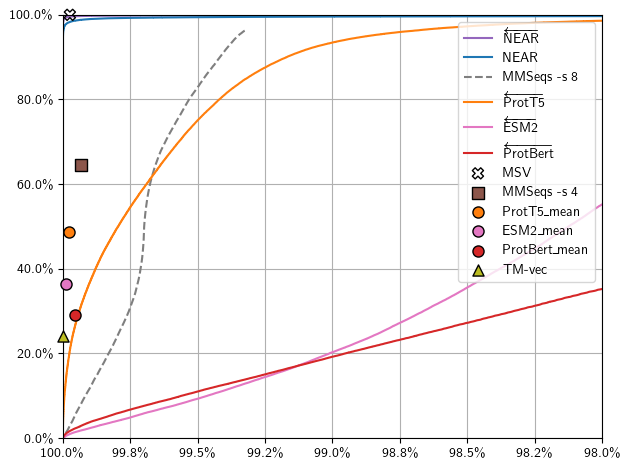

(array([0.9997367, 1.       ]), array([0.99994889, 0.        ]))
(array([0.9997367, 1.       ]), array([0.99660765, 0.        ]))
(array([0.99325235, 0.99325235, 0.99325235, ..., 1.        , 1.        ,
       1.        ]), array([0.96254302, 0.96254302, 0.96254302, ..., 0.        , 0.        ,
       0.        ]))
(array([0.99325235, 0.99325235, 0.99325235, ..., 1.        , 1.        ,
       1.        ]), array([0.8774616, 0.8774616, 0.8774616, ..., 0.       , 0.       ,
       0.       ]))


In [11]:
import matplotlib.ticker as mtick
def plot_results(results, cutoff, eindex, keys):
    key_name = plt.rcParams['text.usetex'] = True
    plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
    for key, color in keys:

        key_name = key
        if key_name == 'NEAR_rev':
            key_name = r'$\boldsymbol{\overleftarrow{\text{NEAR}}}$'
        if key_name == 'ProtT5':
            key_name = r'$\boldsymbol{\overleftarrow{\text{ProtT5}}}$'
        if key_name == 'ESM2':
            key_name = r'$\boldsymbol{\overleftarrow{\text{ESM2}}}$'
        if key_name == 'ProtBert':
            key_name = r'$\boldsymbol{\overleftarrow{\text{ProtBert}}}$'
        if key_name == 'MMSeqs -s 8':
            plt.plot(results[key][eindex][0], results[key][eindex][1], label=key_name, color = color, linestyle='--')
        else:
            plt.plot(results[key][eindex][0], results[key][eindex][1], label=key_name, color = color)

    plt.grid()
    plt.xlim(1.0, cutoff)
    plt.ylim(0.0, 1.0)
    
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 1))
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0, 1))
    

    

def mark_results(results, eindex, keys, markers):
    for key, marker in zip(keys, markers):

        point = np.argmax(results[key[0]][eindex][1])
        plt.scatter(results[key[0]][eindex][0][point], results[key[0]][eindex][1][point], label=key[0], marker=marker, zorder=1000, color=key[1], s=64, edgecolors='black', clip_on=False)



plot_results(decoy_results, 0.98, 0, plot_keys)
mark_results(decoy_results, 0, mark_keys, markers)
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

print(decoy_results['MSV'][0])
print(decoy_results['MSV'][1])

print(decoy_results['MMSeqs -s 8'][0])
print(decoy_results['MMSeqs -s 8'][1])

[0.0921481  0.09214811 0.09214811 ... 1.         1.         1.        ]
[0.99995741 0.99995741 0.99995741 ... 0.         0.         0.        ]


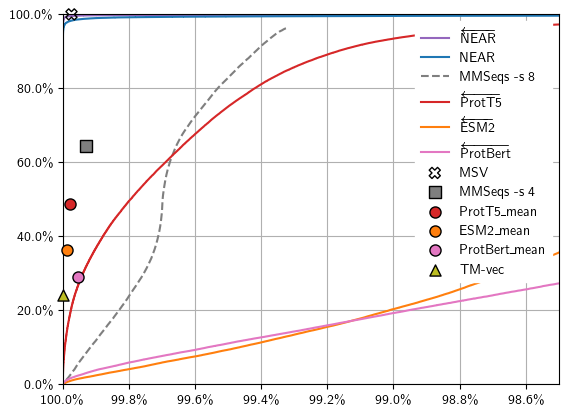

In [23]:
print(decoy_results['NEAR_rev'][0][0])
print(decoy_results['NEAR_rev'][0][1])

#print((decoy_results['MSV'] > 0).sum())
#print((decoy_results['MSV'] < 0).sum())

plot_results(decoy_results, 0.985, 0, plot_keys)
mark_results(decoy_results, 0, mark_keys, markers)

def export_legend(legend, filename="legend.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)



export_legend(plt.legend(edgecolor='white' ,facecolor='white', framealpha=1.0, loc='upper right'))
plt.show()

gogo


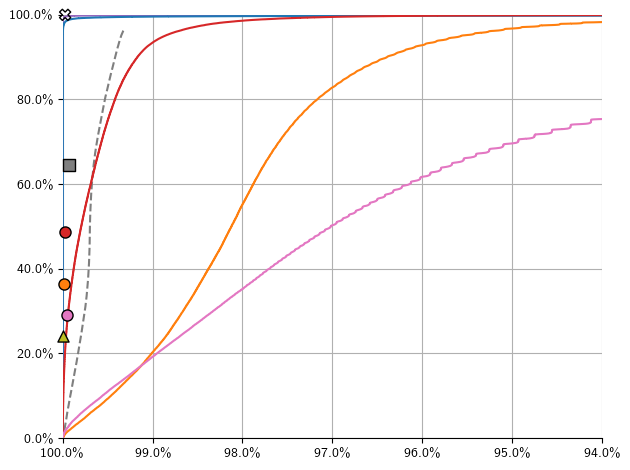

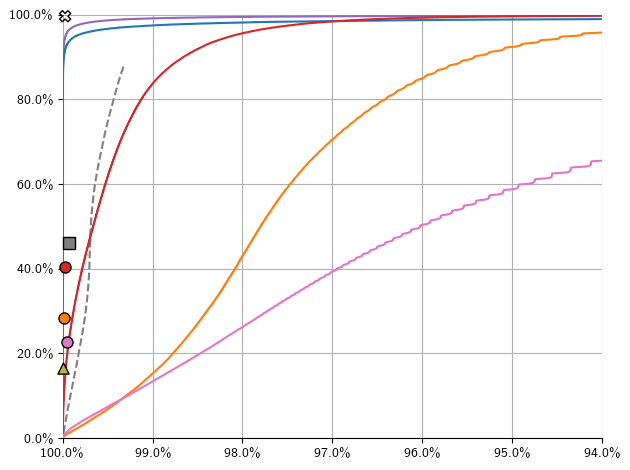

In [20]:
plot_keys = [('NEAR_rev', 'tab:purple'),
             ('NEAR', 'tab:blue'),
             ('MMSeqs -s 8', 'tab:gray'),
             ('ProtT5', 'tab:red'),
             ('ESM2','tab:orange'),
             ('ProtBert','tab:pink')]

plot_colors = ['blue',
               'deepskyblue',
               'fuschia',
               'pink',
               'orange']

mark_keys = [('MSV','none'),
             ('MMSeqs -s 4', 'tab:gray'),
             ('ProtT5_mean', 'tab:red'),
             ('ESM2_mean','tab:orange'),
             ('ProtBert_mean','tab:pink'),
             ('TM-vec','tab:olive')]




markers = ['X',
           #'s',
           's',
           'o',
           'o',
           'o',
           '^']

print("gogo")


plot_results(decoy_results, 0.94, 0, plot_keys)
mark_results(decoy_results, 0, mark_keys, markers)

#plt.legend()
plt.tight_layout()
plt.gca().spines[['right', 'top', 'left']].set_visible(False)
plt.savefig('recall_1e-10_filter_decoy_94.pdf')
plt.show()


plot_results(decoy_results, 0.94, 1, plot_keys)
mark_results(decoy_results, 1, mark_keys, markers)
plt.tight_layout()
plt.gca().spines[['right', 'top', 'left']].set_visible(False)
plt.savefig('recall_1e-3_filter_decoy_94.pdf')
plt.show()

gogo


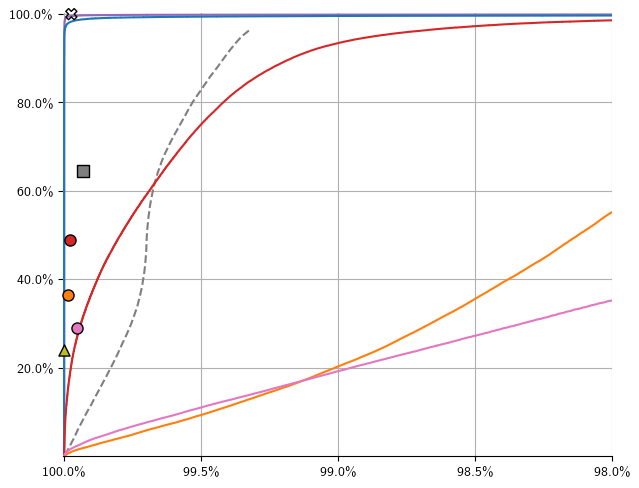

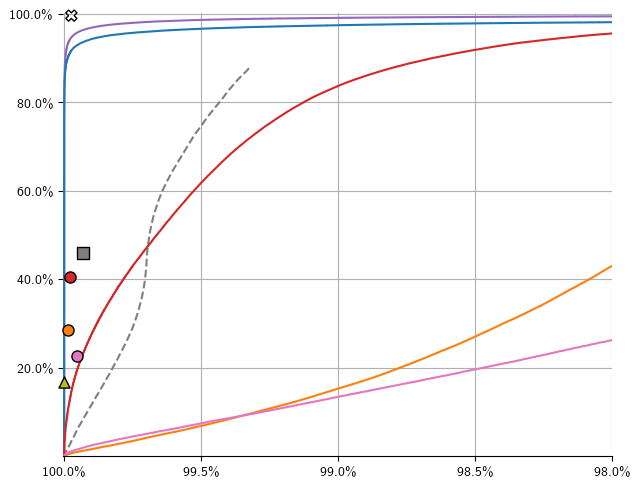

In [21]:
print("gogo")
plt.figure(figsize=(6.5,5))
plot_results(decoy_results, 0.98, 0, plot_keys)
mark_results(decoy_results, 0, mark_keys, markers)

#plt.legend()
plt.tight_layout()
plt.xticks([1.0, 0.995, 0.99, 0.985, 0.98])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0])
plt.gca().spines[['right', 'top', 'left']].set_visible(False)
plt.ylim(0.0, 1.003)
plt.xlim(1.00005, 0.98)

plt.savefig('recall_1e-10_filter_decoy_98.pdf')
plt.show()


plt.figure(figsize=(6.5,5))
plot_results(decoy_results, 0.98, 1, plot_keys)
mark_results(decoy_results, 1, mark_keys, markers)
plt.tight_layout()
plt.xticks([1.0, 0.995, 0.99, 0.985, 0.98])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0])
plt.gca().spines[['right', 'top', 'left']].set_visible(False)
plt.ylim(0.0, 1.003)
plt.xlim(1.00005, 0.98)
plt.savefig('recall_1e-3_filter_decoy_98.pdf')
plt.show()



[(1e-10, 10.0), (0.001, 10.0)]


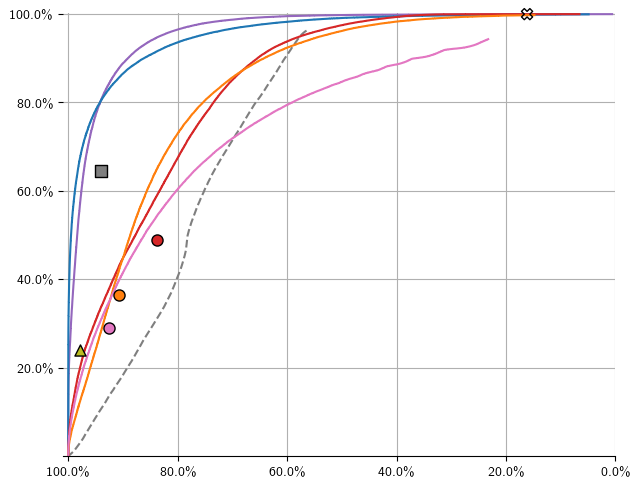

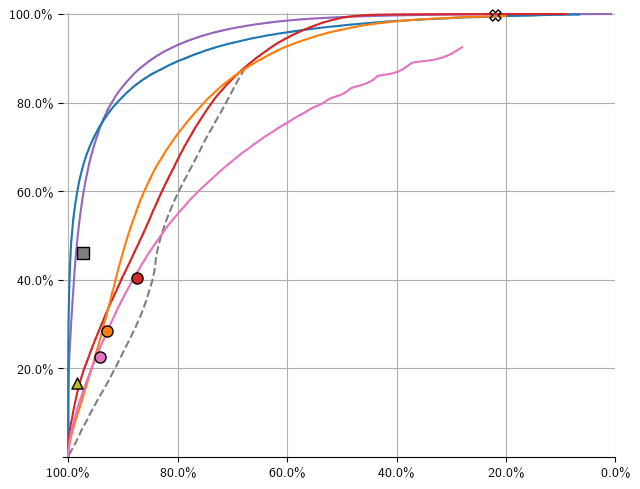

In [22]:
print(cutoff_diffs)

plt.figure(figsize=(6.5,5))
plot_results(real_results, 0.0, 0, plot_keys)
mark_results(real_results, 0, mark_keys, markers)
plt.tight_layout()
plt.gca().spines[['right', 'top', 'left']].set_visible(False)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylim(0.0, 1.003)
plt.xlim(1.01, 0.0)
plt.savefig('recall_1e-10_filter_1e1.pdf')
plt.show()

plt.figure(figsize=(6.5,5))
plot_results(real_results, 0.0, 1, plot_keys)
mark_results(real_results, 1, mark_keys, markers)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylim(0.0, 1.003)
plt.xlim(1.01, 0.0)
plt.tight_layout()
plt.gca().spines[['right', 'top', 'left']].set_visible(False)

plt.savefig('recall_1e-3_filter_1e1.pdf')
plt.show()



In [178]:
print(real_results['MSV'][0])

(array([0.00878765, 1.        ]), array([0.99992333, 0.        ]))


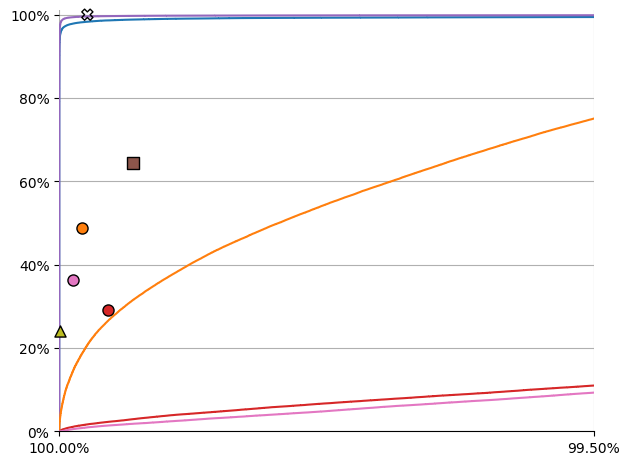

(array([0.4829654, 0.4829654, 0.4829654, ..., 1.       , 1.       ,
       1.       ]), array([9.99574062e-01, 9.99574062e-01, 9.99574062e-01, ...,
       8.51875831e-06, 0.00000000e+00, 0.00000000e+00]))
0
(array([0.9997367, 1.       ]), array([0.99994889, 0.        ]))


In [55]:
#plt.legend()
plot_results(decoy_results, 0.98, 0, plot_keys)
mark_results(decoy_results, 0, mark_keys, markers)
plt.tight_layout()
plt.xticks([1.0, 0.995, 0.99, 0.985, 0.98])
plt.gca().spines[['right', 'top', 'left']].set_visible(False)
plt.ylim(0.0, 1.01)
plt.xlim(1.0000, 0.995)
plt.show()

print(decoy_results['MSV'][0][1])

In [85]:
i = 743722
print(decoy_results['NEAR_rev'][0][0][i], decoy_results['NEAR_rev'][0][1][i])

0.18830802000000002 0.9999488874501653


In [84]:
print(np.argmin((decoy_results['NEAR_rev'][0][1] - decoy_results['MSV'][0][1][0])**2))

743722


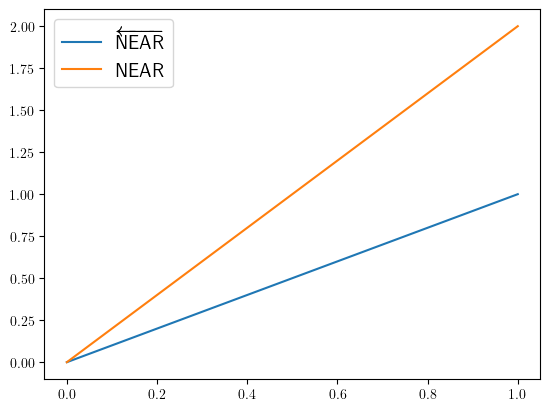

In [57]:

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


plt.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), label=r'$\boldsymbol{\overleftarrow{\text{NEAR}}}$')
plt.plot(np.linspace(0, 1, 20), np.linspace(0, 2, 20), label='NEAR')

plt.legend(fontsize=14)
plt.savefig('/Users/danielolson/Desktop/test.pdf')
plt.show()